In [1]:
import warnings
import autogluon

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from autogluon import TabularPrediction as task
from multiprocessing import cpu_count
from hyperopt import fmin, tpe, hp
from lightgbm import LGBMRegressor
from category_encoders import HelmertEncoder,TargetEncoder, CatBoostEncoder

from itertools import chain


warnings.simplefilter("ignore")

In [2]:
!curl -L -o mercedes.zip https://www.dropbox.com/s/3ywwxgizel850un/mercedes-benz-greener-manufacturing.zip?dl=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  342k  100  342k    0     0  42829      0  0:00:08  0:00:08 --:--:-- 94127


In [3]:
!unzip mercedes.zip
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  mercedes.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [4]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Знакомство с данными

In [5]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [7]:
# посмотрим на не чесловые признаки
train.select_dtypes(include='object')

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n
...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q
4205,j,o,t,d,d,aa,h,h
4206,ak,v,r,a,d,aa,g,e
4207,al,r,e,f,d,aa,l,u


In [8]:
category = train.select_dtypes(include='object').columns.tolist()

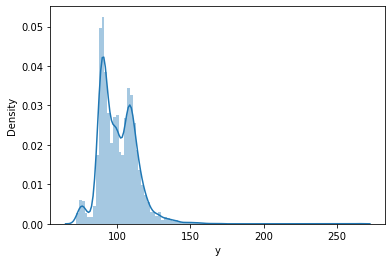

In [9]:
# распределине целевой переменной
sns.distplot(train.y, bins=100);

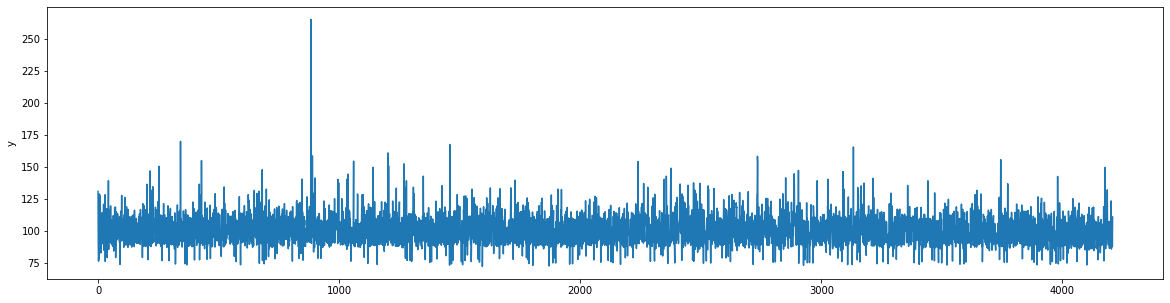

In [10]:
plt.figure(figsize=(20,5))
sns.lineplot(range(len(train)),train.y);

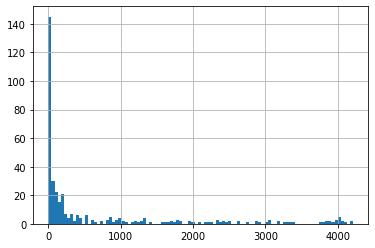

In [11]:
train.drop(columns=['ID']).select_dtypes(include='int64').sum().hist(bins=100);

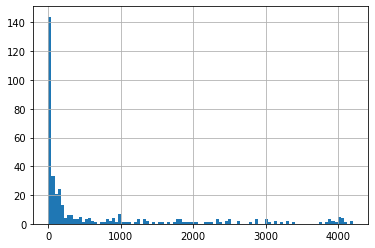

In [12]:
test.drop(columns=['ID']).select_dtypes(include='int64').sum().hist(bins=100);

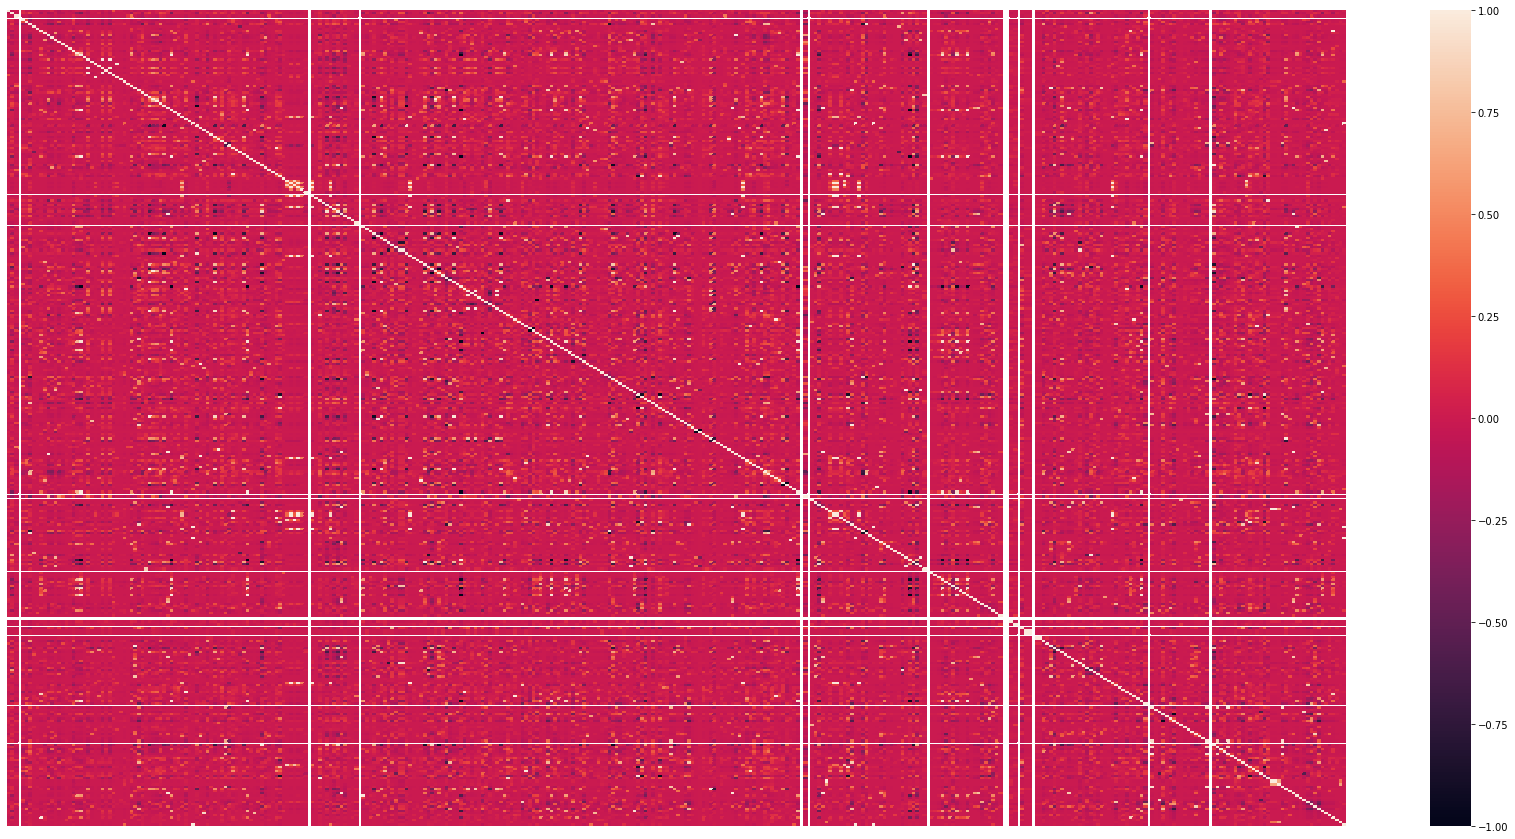

In [13]:
plt.figure(figsize=(30,15))
sns.heatmap(train.corr(), xticklabels=False, yticklabels=False);

In [14]:
# проверим есть ли пересечения трейна с тестом по наблюдением

print(f"Количество пересечений по ID: {len(set(train.ID).intersection(set(test.ID)))}")

Количество пересечений по ID: 0


In [15]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
def save_submission(data, name='submission'):
    data.to_csv(f"{name}.csv", index=False)
    
def report_metrics(y_true, y_pred):
    print(f"MSE: {round(mean_squared_error(y_true, y_pred), 5)}")
    print(f"RMSE: {round(mean_squared_error(y_true, y_pred, squared=False), 5)}")
    print(f"MAE: {round(mean_absolute_error(y_true, y_pred), 5)}")
    print(f"R2: {round(r2_score(y_true, y_pred), 5)}")

# Модели

In [17]:
def save_submission(data, name='submission'):
    data.to_csv(f"{name}.csv", index=False)
    
def report_metrics(y_true, y_pred):
    print(f"MSE: {round(mean_squared_error(y_true, y_pred), 5)}")
    print(f"RMSE: {round(mean_squared_error(y_true, y_pred, squared=False), 5)}")
    print(f"MAE: {round(mean_absolute_error(y_true, y_pred), 5)}")
    print(f"R2: {round(r2_score(y_true, y_pred), 5)}")

## BaseLine

In [18]:
# Попробуем среднее значение
median_pred = np.full(len(train), train.y.mean())
report_metrics(train.y, median_pred)

MSE: 160.72851
RMSE: 12.67787
MAE: 10.0887
R2: 0.0


In [19]:
mean_pred = np.full(len(test), train.y.mean())

In [20]:
save_submission(pd.DataFrame({'ID':test.ID, 'y': mean_pred}), 'baseline_mean')

In [21]:
# Качество метрики R^2 после отправки результата на проверку
#  Private Score: -0.00168
#  Public Score: -0.00038

In [22]:
result = []
result.append(
    {
        'model': 'mean',
        'private_score': -0.00168,
        'public_score': -0.00038
    }
)

## Auto ML

In [23]:
x_train, x_test = train_test_split(train.drop(columns=['ID']), random_state=32, test_size=0.3)

In [24]:
x_train = task.Dataset(x_train)
x_test = task.Dataset(x_test)

In [25]:
%%time
automl_model = task.fit(train_data=x_train, label='y',eval_metric='r2', verbosity=False)

CPU times: user 3min 1s, sys: 5.48 s, total: 3min 7s
Wall time: 1min 22s


In [26]:
automl_pred = automl_model.predict(x_train)
report_metrics(x_train.y, automl_pred)

MSE: 57.79469
RMSE: 7.60228
MAE: 4.67233
R2: 0.63025


In [27]:
automl_pred = automl_model.predict(x_test)
report_metrics(x_test.y, automl_pred)

MSE: 71.72181
RMSE: 8.46887
MAE: 5.45923
R2: 0.58051


In [28]:
automl_pred = automl_model.predict(task.Dataset(test.drop(columns=['ID'])))

In [29]:
save_submission(pd.DataFrame({'ID':test.ID, 'y':automl_pred}), 'automl_predict')

In [30]:
# Качество метрики R^2 после отправки результата на проверку
#  Private Score: 0.54275
#  Public Score: 0.55206

In [31]:

result.append(
    {
        'model': 'automl',
        'private_score': 0.54275,
        'public_score': 0.55206
    }
)

## Преобразуем и почистим признаки

In [32]:
# для поиска коррелирвоных фич
def get_corr_feature(data, threshold=0.9):
  corr = data.corr().abs()
  feature_names = []
  for i in range(corr.shape[0]-1):
    mask = corr.iloc[i, i+1:] >= threshold
    if not mask.sum() > 0:
      continue
    find_feature = corr.iloc[i, i+1:][mask]
    feature_names.append({find_feature.name: find_feature.index.values.tolist()})
  return feature_names

In [33]:
clear_train = train.copy()
features_for_del = []

<AxesSubplot:>

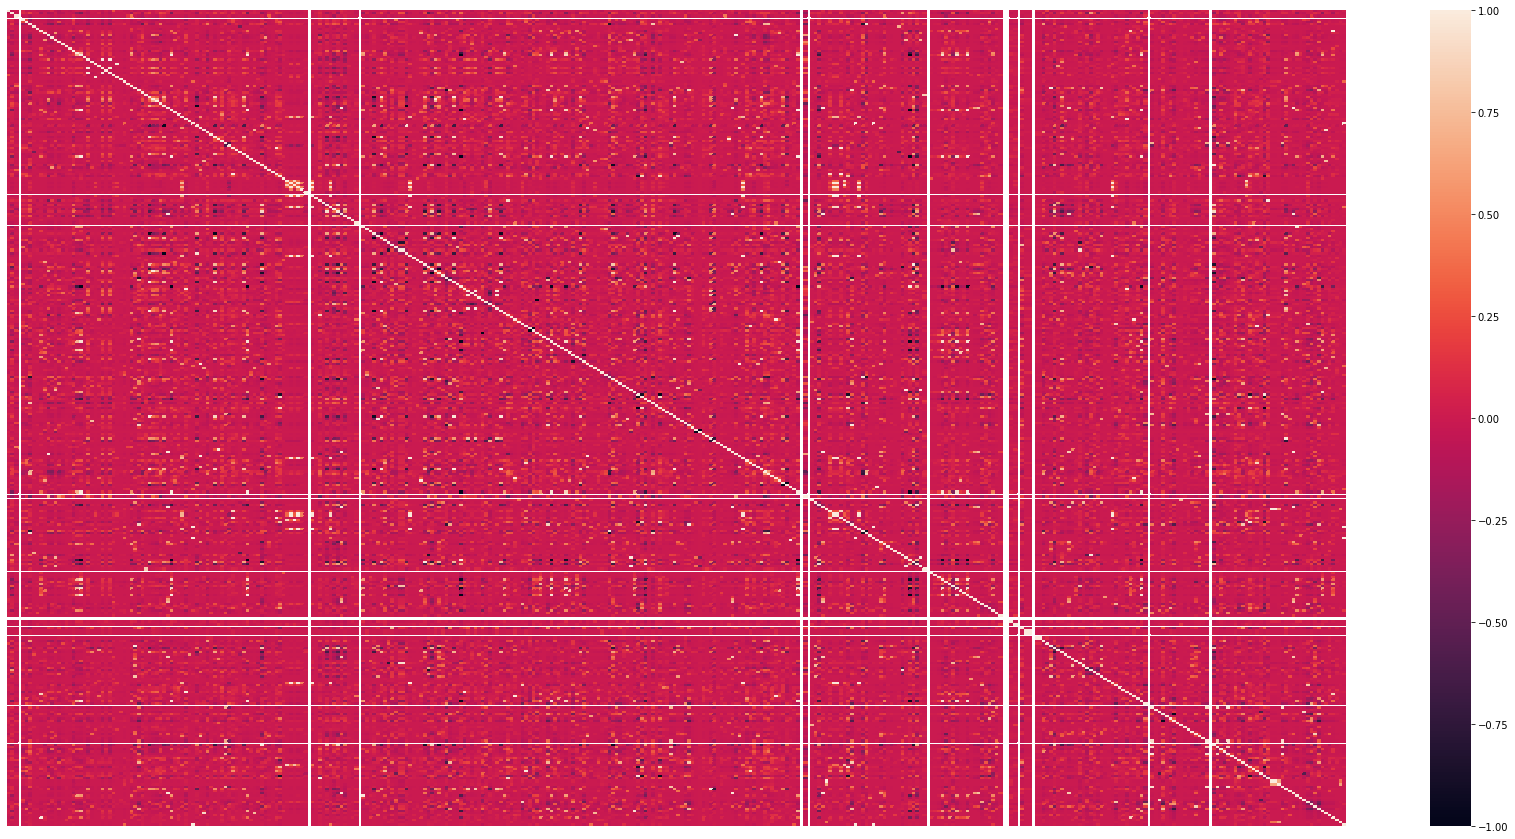

In [34]:
corr_before_del = clear_train.corr()
plt.figure(figsize=(30,15))
sns.heatmap(corr_before_del, xticklabels=False, yticklabels=False)

In [35]:
# найдем константные переменные
std_mask = clear_train.std() == 0
features_for_del += std_mask[std_mask].index.values.tolist()
print(f"Константные признаки: {features_for_del}")


Константные признаки: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


In [36]:
# найдем одинаковые признаки
for i in get_corr_feature(clear_train, 0.99):
  features_for_del += chain(*i.values())
features_for_del = list(set(features_for_del))

In [37]:
print(f"Для удаления: {len(features_for_del)}")

Для удаления: 72


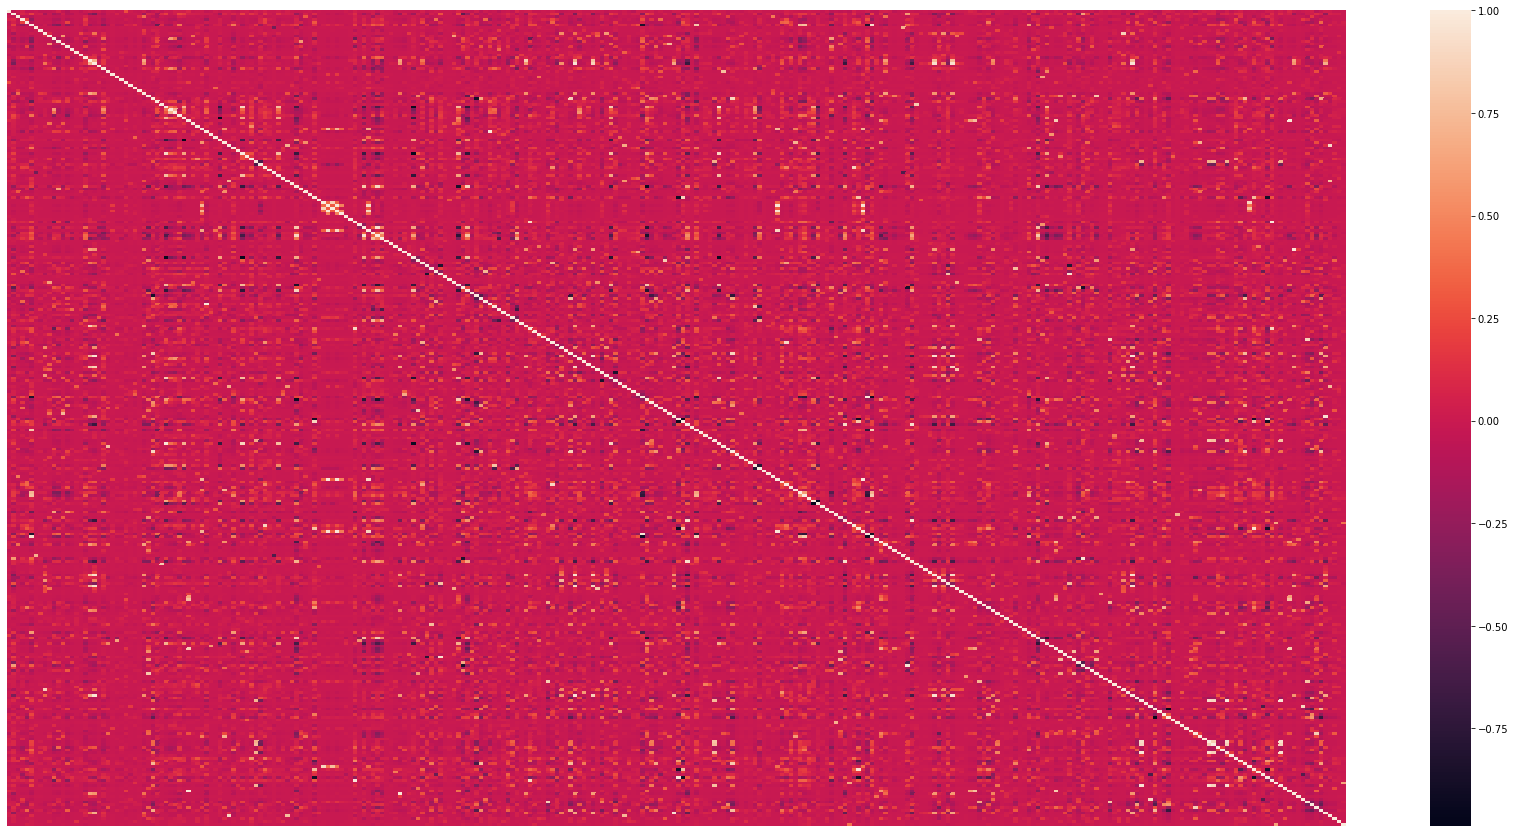

In [38]:
plt.figure(figsize=(30,15))
sns.heatmap(clear_train.drop(columns=features_for_del).corr(), xticklabels=False, yticklabels=False);

In [39]:
clear_train = clear_train.drop(columns=features_for_del)
clear_test = test.drop(columns=features_for_del)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(clear_train.drop(columns=['y', 'ID']), clear_train.y, random_state=32, test_size=0.3)

In [41]:
# Преобразуем категориальные признаки
encoder = CatBoostEncoder(cols=category)
x_train = encoder.fit_transform(x_train, y_train)
x_test = encoder.transform(x_test)

In [42]:
# для подбора гиперпараметров
def opt_model_param(model, params, data, target):
    x_train, x_test, y_train, y_test = train_test_split(
        data, target, random_state=32, test_size=0.3
    )
    
#     encoder = CatBoostEncoder(cols=category)
#     x_train = encoder.fit_transform(x_train, y_train)
#     x_test = encoder.transform(x_test)
    
    def fit_predict(params=params):
        model.set_params(**params)
        model.fit(x_train, y_train)
        return -r2_score(y_test, model.predict(x_test))
           
    return fmin(fn=fit_predict, space=params, algo=tpe.suggest, max_evals=20)

## Linear regression

In [43]:
%%time
# подбор гиперпараметров
params = {
    'alpha': hp.uniform('alpha', 0., 1.),
    'l1_ratio':  hp.uniform('l1_ratio', 0., 1.)
}
liner_best_params = opt_model_param(ElasticNet(), params, x_train, y_train)

100%|██████████| 20/20 [00:01<00:00, 11.02trial/s, best loss: -0.5470139913668193]
CPU times: user 3.66 s, sys: 3.48 s, total: 7.14 s
Wall time: 1.83 s


In [44]:
liner_best_params

{'alpha': 0.03401438743373064, 'l1_ratio': 0.9132169263598737}

In [45]:
liner_model = ElasticNet(**liner_best_params)
liner_model.fit(x_train, y_train)
report_metrics(y_train, liner_model.predict(x_train))

MSE: 69.35612
RMSE: 8.32803
MAE: 5.2447
R2: 0.55628


In [46]:
report_metrics(y_test, liner_model.predict(x_test))

MSE: 72.35951
RMSE: 8.50644
MAE: 5.54123
R2: 0.57678


In [47]:
liner_model_predict = liner_model.predict(
    encoder.transform(
        clear_test.drop(columns=['ID'])
    )
)

In [48]:
save_submission(pd.DataFrame({'ID':test.ID, 'y': liner_model_predict}), 'liner_model')

In [49]:
# Качество метрики R^2 после отправки результата на проверку
#  Private Score: 0.54011
#  Public Score: 0.54391

In [50]:
result.append(
    {
        'model': 'liner',
        'private_score': 0.54011,
        'public_score': 0.54391
    }
)

## KNN [](http://)Regressor

In [51]:
%%time
# подбор гиперпараметров

params = {
    'n_neighbors': hp.choice('n_neighbors', range(2, 1000))
}
knn_best_params = opt_model_param(KNeighborsRegressor(), params, x_train, y_train)

100%|██████████| 20/20 [00:20<00:00,  1.00s/trial, best loss: -0.5397976138418341]
CPU times: user 20.5 s, sys: 137 ms, total: 20.6 s
Wall time: 20.4 s


In [52]:
knn_best_params

{'n_neighbors': 40}

In [53]:
knn_model = KNeighborsRegressor(**knn_best_params)
knn_model.fit(x_train, y_train)
report_metrics(y_train, knn_model.predict(x_train))

MSE: 70.70717
RMSE: 8.40876
MAE: 5.35147
R2: 0.54764


In [54]:
report_metrics(y_test, knn_model.predict(x_test))

MSE: 73.16612
RMSE: 8.55372
MAE: 5.63192
R2: 0.57207


In [55]:
knn_model_predict = knn_model.predict(
    encoder.transform(
        clear_test.drop(columns=['ID'])
    )
)

In [56]:
save_submission(pd.DataFrame({'ID':test.ID, 'y': knn_model_predict}), 'knn_model')

In [57]:
# Качество метрики R^2 после отправки результата на проверку
#  Private Score: 0.52882
#  Public Score: 0.53852

In [58]:
result.append(
    {
        'model': 'knn',
        'private_score': 0.52882,
        'public_score': 0.53852
    }
)

## LGBMRegressor

In [59]:
%%time

# подбор гиперпараметров

params = {
    'max_depth': hp.choice('max_depth', range(1, 3)),
    'n_estimators': hp.choice('n_estimators', range(1, 300)),
    'reg_alpha': hp.uniform('reg_alpha', 0., 1),
    'reg_lambda': hp.uniform('reg_lambda', 0., 1),
    'num_leaves': hp.choice('num_leaves', range(1, 100)),
    'min_child_samples': hp.choice('min_child_samples', range(1, 100))
}
lgbm_best_params = opt_model_param(LGBMRegressor(), params, x_train, y_train)

100%|██████████| 20/20 [00:03<00:00,  6.28trial/s, best loss: -0.5483167614561489]
CPU times: user 5.08 s, sys: 56.3 ms, total: 5.14 s
Wall time: 3.29 s


In [60]:
lgbm_best_params

{'max_depth': 1,
 'min_child_samples': 6,
 'n_estimators': 29,
 'num_leaves': 52,
 'reg_alpha': 0.5805093387879803,
 'reg_lambda': 0.7923609005726019}

In [61]:
lgbm_model = LGBMRegressor(**lgbm_best_params)
lgbm_model.fit(x_train, y_train)
report_metrics(y_train, lgbm_model.predict(x_train))

MSE: 74.68154
RMSE: 8.64185
MAE: 5.5764
R2: 0.52221


In [62]:
report_metrics(y_test, lgbm_model.predict(x_test))

MSE: 76.27249
RMSE: 8.73341
MAE: 5.84712
R2: 0.5539


In [63]:
lgbm_model_predict = lgbm_model.predict(
    encoder.transform(
        clear_test.drop(columns=['ID'])
    )
)

In [64]:
save_submission(pd.DataFrame({'ID':test.ID, 'y': lgbm_model_predict}), 'lgbm_model')

In [65]:
# Качество метрики R^2 после отправки результата на проверку
#  Private Score: 0.54703
#  Public Score: 0.54729

In [66]:
result.append(
    {
        'model': 'lgbm',
        'private_score': 0.54703,
        'public_score': 0.54729
    }
)

In [67]:
df_result = pd.DataFrame(result)

# Сравнение результатов

<AxesSubplot:xlabel='model', ylabel='public_score'>

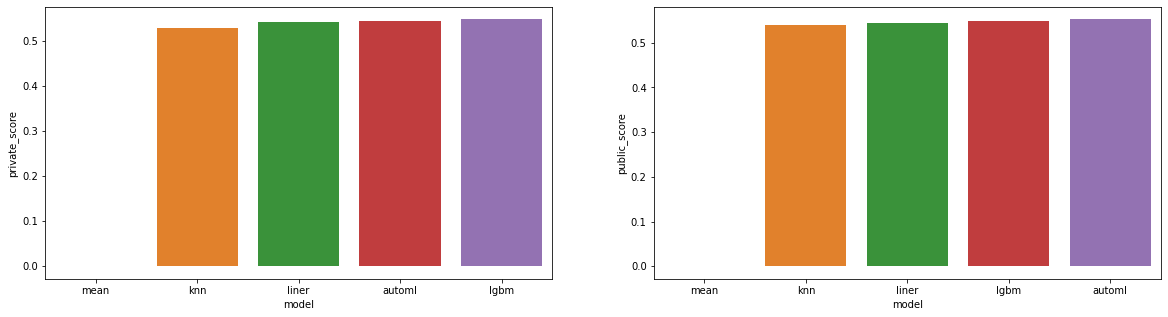

In [68]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.barplot(x='model', y='private_score', data=df_result.sort_values(by='private_score'))

plt.subplot(1,2,2)
sns.barplot(x='model', y='public_score', data=df_result.sort_values(by='public_score'))


In [69]:
df_result

,model,private_score,public_score
0,mean,-0.00168,-0.00038
1,automl,0.54275,0.55206
2,liner,0.54011,0.54391
3,knn,0.52882,0.53852
4,lgbm,0.54703,0.54729
